### Shanghai Rental Data 

This data is scrapied from Lianjia.com (as of 10/01/2020). The csv files contains name, rental type, # of beds, price, longitude, latitude, balcony, deposit, apartment, rent_description, touring, transportation, independent bath, furnished, new listing, size, orientation, leve, elevator, parking and amenities information.

Attributes:
- name: name of listing
- type: sublease or entire leasing (all entire)
- beds: bedroom number
- price
- lon/lat: coordinates
- balcony, deposit(whether has deposit policy), apartment, rent_description, touring availability, close to transportation, independent bath, furnished, new listing: NO-0, YES-1.
- size: square meters
- orientation: facing of the windows, south-1, southeast-2, east-3, north-4, southwest-5, west-6, northwest-7, northeast-8, unknown-0
- level: levels of the listing, basement-0, low level(1-15)-1, mid level(15-25)-2, high level(>25)-3
- parking: no parking-0, extra cost avalaible-1, free parking-2
- amenities: amenities number 

In [1]:
import pandas as pd
import numpy as np
import geopandas 

In [2]:
df = pd.read_csv('lianjia_shanghai.csv', sep =',', encoding='utf_8_sig', header=None)

In [3]:
df.head()

0   1  2       3           4          5   6   7   8   9   ...  11  12  \
0   三兴小区  整租  1  4500.0  121.466522  31.258257   0   0   0   0  ...   1   0   
1  华龙大酒店  整租  1  3700.0  121.458494  31.262110   0   0   0   0  ...   1   0   
2   协和大厦  整租  2  8500.0  121.464014  31.265904   0   0   0   0  ...   1   0   
3   安源小区  整租  2  8200.0  121.457048  31.251189   0   0   0   0  ...   0   0   
4   和泰花园  整租  2  9000.0  121.457915  31.263993   0   0   0   0  ...   1   0   

   13  14  15  16       17 18    19 20  
0   1   0  31   北   低楼层/7层  无  暂无数据  5  
1   0   0  43   南  中楼层/16层  无  暂无数据  0  
2   0   0  92   南  中楼层/20层  有  暂无数据  7  
3   1   0  78   南  低楼层/21层  有  暂无数据  8  
4   0   0  93   南  低楼层/17层  有  租用车位  8  

[5 rows x 21 columns]

### ETL

ETL process, clean and translate the dataframe into English.

In [4]:
def cleanRental(df):
    # drop duplicates
    df_copy = df.copy()
    df_copy = df_copy.drop_duplicates()
    #rename columns 
    cols = ['name', 'type', 'beds', 'price', 'lon', 'lat', 'balcony', 'deposit', 'apartment', 'rent_description', 
            'touring', 'close_to_transportation', 'independent_bath', 'furnished', 'new_listing', 'size', 
            'orientation', 'level', 'elevator', 'parking', 'amenities']
    df_copy.columns = cols
    # remove type since it's all entire apartment
    df_copy.drop('type', axis=1, inplace=True)
    # clean beds type unreadable
    df_copy.drop(10811, axis=0, inplace=True)
    df_copy.beds = df_copy.beds.astype(int)
    # translate orientation
    df_copy.orientation = df_copy.orientation.apply(lambda x: x.split(' ')[0])
    rep = {'南': 1, '东南': 2, '东': 3, '北': 4, '西南': 5, '西': 6, '西北': 7, '东北':8, '未知': 0}
    df_copy.orientation.replace(rep, inplace=True)
    # clean levels 
    df_copy.level = df_copy.level.apply(lambda x: x.split('/')[0])
    df_copy.level.replace({'地下室': 0, '低楼层': 1, '中楼层': 2, '高楼层':3}, inplace=True)
    #df_copytranslate elevator
    df_copy.elevator.replace({'无':0, '有':1}, inplace=True)
    # translate parking info
    df_copy.parking.replace({'暂无数据': 0, '租用车位': 1, '免费使用': 2}, inplace=True)
    # drop balcony apartment, and independent bath since it's all none
    df_copy.drop(['balcony','independent_bath', 'apartment'], axis=1, inplace=True)
    return df_copy

In [5]:
df_clean = cleanRental(df)

In [6]:
df_clean.head()

name  beds   price         lon        lat  deposit  rent_description  \
0   三兴小区     1  4500.0  121.466522  31.258257        0                 0   
1  华龙大酒店     1  3700.0  121.458494  31.262110        0                 0   
2   协和大厦     2  8500.0  121.464014  31.265904        0                 0   
3   安源小区     2  8200.0  121.457048  31.251189        0                 0   
4   和泰花园     2  9000.0  121.457915  31.263993        0                 0   

   touring  close_to_transportation  furnished  new_listing  size  \
0        1                        1          1            0    31   
1        1                        1          0            0    43   
2        1                        1          0            0    92   
3        0                        0          1            0    78   
4        0                        1          0            0    93   

   orientation  level  elevator  parking  amenities  
0            4      1         0        0          5  
1            1      2         0        0          0  
2            1      2         1        0          7  
3            1      1         1        0          8  
4            1      1         1        1          8

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10994 entries, 0 to 10998
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     10994 non-null  object 
 1   beds                     10994 non-null  int64  
 2   price                    10994 non-null  float64
 3   lon                      10994 non-null  float64
 4   lat                      10994 non-null  float64
 5   deposit                  10994 non-null  int64  
 6   rent_description         10994 non-null  int64  
 7   touring                  10994 non-null  int64  
 8   close_to_transportation  10994 non-null  int64  
 9   furnished                10994 non-null  int64  
 10  new_listing              10994 non-null  int64  
 11  size                     10994 non-null  int64  
 12  orientation              10994 non-null  int64  
 13  level                    10994 non-null  int64  
 14  elevator              

In [8]:
df_clean.describe()

beds          price           lon           lat       deposit  \
count  10994.000000   10994.000000  10994.000000  10994.000000  10994.000000   
mean       2.286429   10230.316900    121.421169     31.202792      0.004821   
std        1.094175   14199.284667      0.114319      0.100173      0.069268   
min        0.000000    1000.000000    121.017122     30.718873      0.000000   
25%        2.000000    4500.000000    121.366116     31.157198      0.000000   
50%        2.000000    6500.000000    121.432420     31.214656      0.000000   
75%        3.000000   11000.000000    121.481756     31.256547      0.000000   
max        9.000000  500000.000000    121.929623     31.533224      1.000000   

       rent_description       touring  close_to_transportation     furnished  \
count      10994.000000  10994.000000             10994.000000  10994.000000   
mean           0.000728      0.264781                 0.499727      0.617155   
std            0.026967      0.441236                 0.500023      0.486103   
min            0.000000      0.000000                 0.000000      0.000000   
25%            0.000000      0.000000                 0.000000      0.000000   
50%            0.000000      0.000000                 0.000000      1.000000   
75%            0.000000      1.000000                 1.000000      1.000000   
max            1.000000      1.000000                 1.000000      1.000000   

        new_listing          size   orientation         level      elevator  \
count  10994.000000  10994.000000  10994.000000  10994.000000  10994.000000   
mean       0.159360    104.530471      1.247317      2.005639      0.498090   
std        0.366028     89.769158      0.908562      0.819554      0.500019   
min        0.000000      8.000000      0.000000      0.000000      0.000000   
25%        0.000000     55.000000      1.000000      1.000000      0.000000   
50%        0.000000     86.000000      1.000000      2.000000      0.000000   
75%        0.000000    124.000000      1.000000      3.000000      1.000000   
max        1.000000   3218.000000      8.000000      3.000000      1.000000   

            parking     amenities  
count  10994.000000  10994.000000  
mean       0.355194      6.059942  
std        0.583590      3.338066  
min        0.000000      0.000000  
25%        0.000000      4.000000  
50%        0.000000      7.000000  
75%        1.000000      8.000000  
max        2.000000     10.000000

### Exploratory analysis - Data visualization

In [9]:
# import packages
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
import matplotlib as mpl
#ffrom sklearn.preprocessing import MinMaxScaler

%matplotlib inline

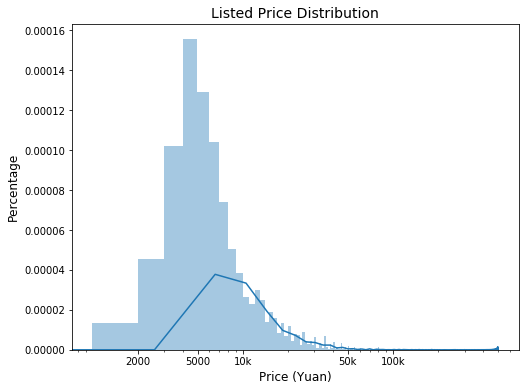

In [324]:
# visualize price distribution 
plt.figure(figsize=(8, 6))
sns.distplot(df_clean.price, bins=500, kde=True)
plt.xscale('log') # Log transform the price 
plt.xticks([2000, 5000, 10000, 50000, 100000], ['2000', '5000', '10k', '50k', '100k'])
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price (Yuan)', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14);

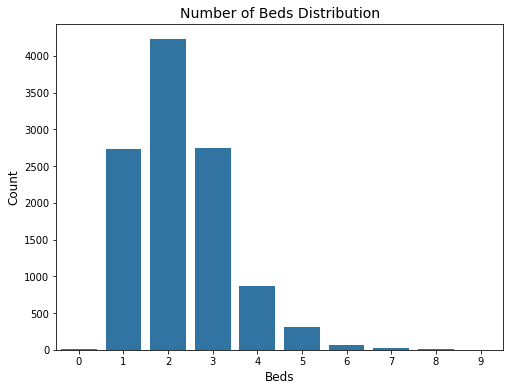

In [325]:
# visualize beds distribution
plt.figure(figsize=(8, 6))
sns.countplot(df_clean.beds, color=sns.color_palette()[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Beds', fontsize=12)
plt.title('Number of Beds Distribution', fontsize=14);

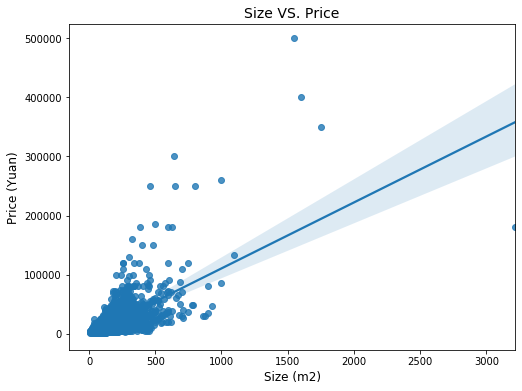

In [326]:
# visualize relationship between size and price
plt.figure(figsize=(8, 6))
sns.regplot(x='size', y='price', data=df_clean)
plt.ylabel('Price (Yuan)', fontsize=12)
plt.xlabel('Size (m2)', fontsize=12)
plt.title('Size VS. Price', fontsize=14);

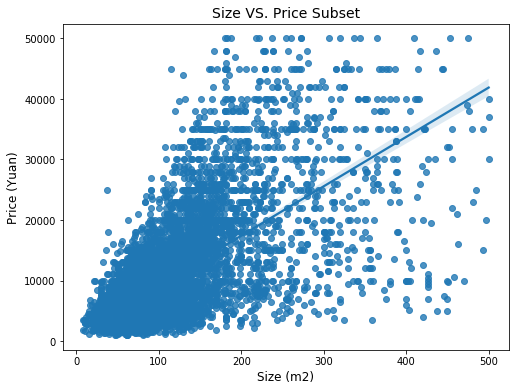

In [327]:
# subset price and size and check the plot
df_sub = df_clean[(df_clean.price <= 50000) & (df_clean['size']<= 500)]
plt.figure(figsize=(8, 6))
sns.regplot(x='size', y='price', data=df_sub)
plt.ylabel('Price (Yuan)', fontsize=12)
plt.xlabel('Size (m2)', fontsize=12)
plt.title('Size VS. Price Subset', fontsize=14);

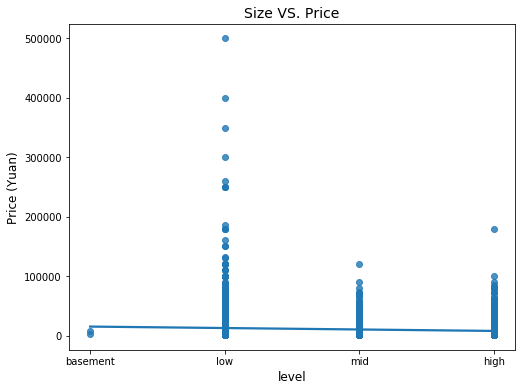

In [328]:
# visualize relationship between level and price 
plt.figure(figsize=(8, 6))
sns.regplot(x='level', y='price', data=df_clean)
plt.ylabel('Price (Yuan)', fontsize=12)
plt.xlabel('level', fontsize=12)
plt.xticks([0, 1, 2, 3], ['basement', 'low', 'mid', 'high'])
plt.title('Size VS. Price', fontsize=14);

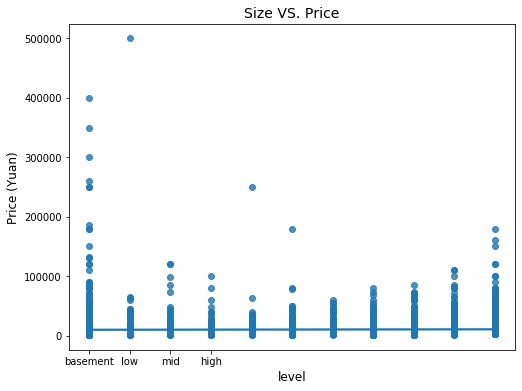

In [329]:
# visualize relationship between amenities and price 
plt.figure(figsize=(8, 6))
sns.regplot(x='amenities', y='price', data=df_clean)
plt.ylabel('Price (Yuan)', fontsize=12)
plt.xlabel('level', fontsize=12)
plt.xticks([0, 1, 2, 3], ['basement', 'low', 'mid', 'high'])
plt.title('Size VS. Price', fontsize=14);

import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(np.log(df_clean.price).min(), np.log(df_clean.price).max())
n_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [ ]:
df_clean['log_price'] = df_clean.price.transform(np.log)

In [430]:
# build interactive map to see the density of listing
m = folium.Map(location=[31.2389, 121.4992], zoom_start=11)
cmap = cm.LinearColormap(colors=['blue', 'red']).scale(df_clean.log_price.min(), df_clean.log_price.max())
for lat, lon, price in zip(df_clean['lat'], df_clean['lon'], df_clean.log_price):
     folium.CircleMarker(location=[lat, lon],
                            radius=3,
                            color=None,
                            fill=True,
                            fill_opacity=0.5,
                            fill_color=cmap(price),
                           ).add_to(m)
m.save('lianjia_shanghai.html')
m

In [240]:
# read geodata
df_geo = geopandas.read_file('shanghai.geojson')

In [247]:
import json
import requests
url = 'https://geo.datav.aliyun.com/areas_v2/bound/310000_full.json'
r = requests.get(url).json()

In [271]:
df_geo2 = pd.json_normalize(r['features'])

type  properties.adcode properties.name        properties.center  \
0   Feature             310101             黄浦区  [121.490317, 31.222771]   
1   Feature             310104             徐汇区   [121.43752, 31.179973]   
2   Feature             310105             长宁区    [121.4222, 31.218123]   
3   Feature             310106             静安区  [121.448224, 31.229003]   
4   Feature             310107             普陀区  [121.392499, 31.241701]   
5   Feature             310109             虹口区   [121.491832, 31.26097]   
6   Feature             310110             杨浦区  [121.522797, 31.270755]   
7   Feature             310112             闵行区  [121.375972, 31.111658]   
8   Feature             310113             宝山区  [121.489934, 31.398896]   
9   Feature             310114             嘉定区  [121.250333, 31.383524]   
10  Feature             310115            浦东新区  [121.567706, 31.245944]   
11  Feature             310116             金山区  [121.330736, 30.724697]   
12  Feature             310117             松江区   [121.223543, 31.03047]   
13  Feature             310118             青浦区  [121.113021, 31.151209]   
14  Feature             310120             奉贤区  [121.458472, 30.912345]   
15  Feature             310151             崇明区  [121.397516, 31.626946]   

        properties.centroid  properties.childrenNum properties.level  \
0   [121.483572, 31.215946]                       0         district   
1   [121.439404, 31.162992]                       0         district   
2    [121.380949, 31.20737]                       0         district   
3   [121.450659, 31.270821]                       0         district   
4   [121.392058, 31.257885]                       0         district   
5   [121.485443, 31.276649]                       0         district   
6    [121.529302, 31.29835]                       0         district   
7   [121.418901, 31.087213]                       0         district   
8   [121.404861, 31.392111]                       0         district   
9   [121.244394, 31.358136]                       0         district   
10  [121.742177, 31.083823]                       0         district   
11  [121.255144, 30.818932]                       0         district   
12  [121.220231, 31.015194]                       0         district   
13  [121.085182, 31.124658]                       0         district   
14   [121.56251, 30.897998]                       0         district   
15  [121.568484, 31.635916]                       0         district   

    properties.parent.adcode  properties.subFeatureIndex properties.acroutes  \
0                     310000                           0    [100000, 310000]   
1                     310000                           1    [100000, 310000]   
2                     310000                           2    [100000, 310000]   
3                     310000                           3    [100000, 310000]   
4                     310000                           4    [100000, 310000]   
5                     310000                           5    [100000, 310000]   
6                     310000                           6    [100000, 310000]   
7                     310000                           7    [100000, 310000]   
8                     310000                           8    [100000, 310000]   
9                     310000                           9    [100000, 310000]   
10                    310000                          10    [100000, 310000]   
11                    310000                          11    [100000, 310000]   
12                    310000                          12    [100000, 310000]   
13                    310000                          13    [100000, 310000]   
14                    310000                          14    [100000, 310000]   
15                    310000                          15    [100000, 310000]   

   geometry.type                               geometry.coordinates  
0   MultiPolygon  [[[[121.475987, 31.187885], [121.474944, 31.18...  
1   M

In [265]:
from shapely.geometry import Polygon, Point
dist = []
for j in range(df_clean.shape[0]):
    p = Point(df_clean.lon.tolist()[j], df_clean.lat.tolist()[j])
    for i in range(df_geo2.shape[0]):
        if Polygon(df_geo2['geometry.coordinates'][i][0][0]).contains(p):
            dist.append(i)

In [270]:
df_clean['district'] = dist
df_clean['district'].value_counts()

10    1558
7     1357
3      992
1      942
4      839
9      793
2      782
8      774
12     741
0      686
13     596
6      380
14     300
5      211
11      42
15       1
Name: district, dtype: int64

In [272]:
df_clean.head()

name  beds   price         lon        lat  deposit  rent_description  \
0   三兴小区     1  4500.0  121.466522  31.258257        0                 0   
1  华龙大酒店     1  3700.0  121.458494  31.262110        0                 0   
2   协和大厦     2  8500.0  121.464014  31.265904        0                 0   
3   安源小区     2  8200.0  121.457048  31.251189        0                 0   
4   和泰花园     2  9000.0  121.457915  31.263993        0                 0   

   touring  close_to_transportation  furnished  new_listing  size  \
0        1                        1          1            0    31   
1        1                        1          0            0    43   
2        1                        1          0            0    92   
3        0                        0          1            0    78   
4        0                        1          0            0    93   

   orientation  level  elevator  parking  amenities  district  log_price  
0            4      1         0        0          5         3   8.411833  
1            1      2         0        0          0         3   8.216088  
2            1      2         1        0          7         3   9.047821  
3            1      1         1        0          8         3   9.011889  
4            1      1         1        1          8         3   9.104980

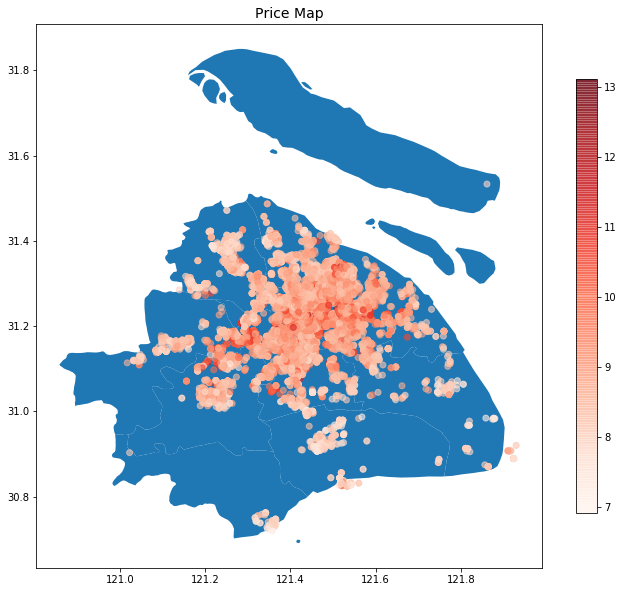

In [672]:
gpd.plot(figsize=(12,10))
scatter_map = plt.scatter(data=df_clean, x='lon', y='lat', c='log_price', alpha=0.6, cmap='Reds')
plt.colorbar(shrink = 0.8)
plt.title('Price Map', fontsize=14);

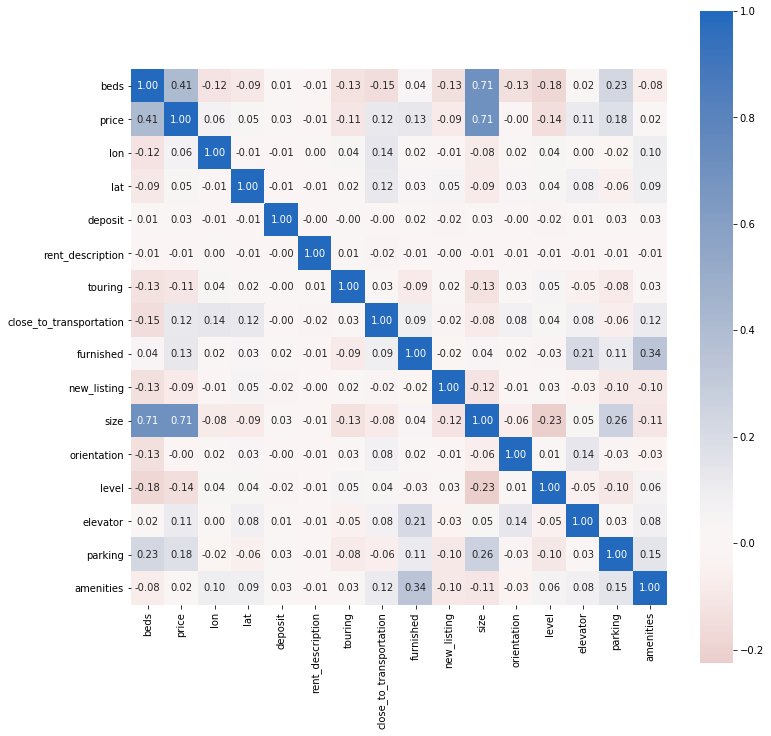

In [405]:
# last check correlation
plt.figure(figsize=(12, 12))
sns.heatmap(df_clean.corr(), square=True, annot=True, fmt = '.2f', cmap = 'vlag_r', center=0);

In [273]:
# save cleaned data
df_clean.to_csv('liangjia_sh_cleaned.csv', index=False)

### Model Build

1. Try to predict price based on features.

In [185]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import pickle
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

/Users/xiyuewang/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [186]:
# create a function to visualize the distribution of the prediction and the test
def DistributionPlot(y_test, pred, RedName='Actual Values (Train)', BlueName='Predicted Values (Train)', Title = 
                     'Distribution Plot of Predicted Value - Keras'):
    plt.figure(figsize=(6, 4))

    ax1 = sns.distplot(y_test, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(pred, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()

In [187]:
sum(df_clean.price<=100000)/df_clean.shape[0]

0.9975441149718028

In [188]:
df_sub = df_clean[df_clean.price<=100000]
df_sub.head()

name  beds   price         lon        lat  deposit  rent_description  \
0   三兴小区     1  4500.0  121.466522  31.258257        0                 0   
1  华龙大酒店     1  3700.0  121.458494  31.262110        0                 0   
2   协和大厦     2  8500.0  121.464014  31.265904        0                 0   
3   安源小区     2  8200.0  121.457048  31.251189        0                 0   
4   和泰花园     2  9000.0  121.457915  31.263993        0                 0   

   touring  close_to_transportation  furnished  new_listing  size  \
0        1                        1          1            0    31   
1        1                        1          0            0    43   
2        1                        1          0            0    92   
3        0                        0          1            0    78   
4        0                        1          0            0    93   

   orientation  level  elevator  parking  amenities  district  
0            4      1         0        0          5         3  
1            1      2         0        0          0         3  
2            1      2         1        0          7         3  
3            1      1         1        0          8         3  
4            1      1         1        1          8         3

In [193]:
df_clean['log_price'] = df_clean.price.transform(np.log)

In [194]:
# split data, we will only use data with price < 100,000 which is 99.75% of the dataset
y = df_clean.log_price
X = df_clean.iloc[:, 1:].drop(['price', 'log_price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Ridge

In [195]:
# Ridge regression model
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


ridge = Ridge()
alphas = [0.0001, 0.001, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 5, 10]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

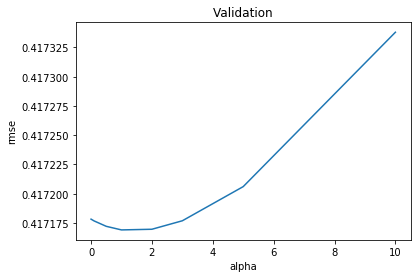

In [196]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation')
plt.xlabel("alpha")
plt.ylabel("rmse");

In [197]:
# fit the test data
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print(ridge.score(X_test, y_test))

0.7154750398142462


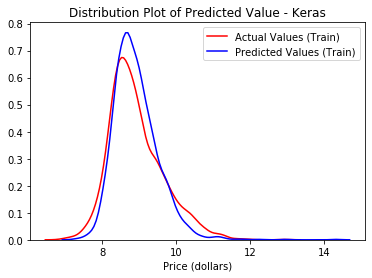

In [198]:
DistributionPlot(y_test, pred)

### Lasso

In [199]:
alphas = [10, 1, 0.1, 0.001, 0.0005, 0.0001]
cv_lasso = LassoCV(alphas = alphas, cv=5, random_state=0).fit(X_train, y_train)

In [200]:
print(cv_lasso.score(X_test, y_test))
pred = cv_lasso.predict(X_test)

0.7155411350578988


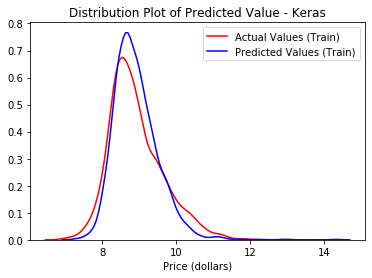

In [201]:
DistributionPlot(y_test, pred)

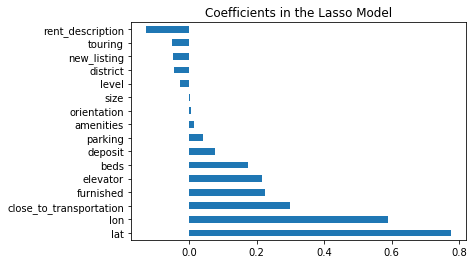

In [202]:
# check important factors contribute to price 
coef = pd.Series(cv_lasso.coef_, index = X_train.columns)
coef.sort_values(ascending=False).plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model');

In [204]:
coef.to_csv('coefs.csv', header=False)

### Random forest

In [588]:
rf = RandomForestRegressor(random_state=0)
params = {'n_estimators': [50, 100, 200], 'min_samples_split': [2, 5, 10], 'max_depth': [1, 3, 5, 10, 20, 50]}
rf_cv = GridSearchCV(rf, param_grid=params, cv=5)

In [589]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [590]:
print(rf_cv.best_params_)
pred = rf_cv.predict(X_test)
print(rf_cv.score(X_test, y_test))

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
0.9069701637474163


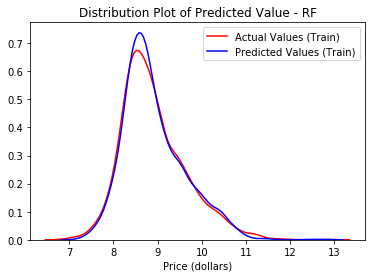

In [592]:
DistributionPlot(y_test, pred)

In [594]:
# save model
with open('rf_cv.pkl', 'wb') as f:
    pickle.dump(rf_cv.best_params_, f)

### XGBoost

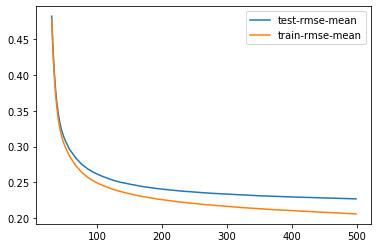

In [599]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {'max_depth':2, 'eta':0.1}
xgb_model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
xgb_model.loc[30:,['test-rmse-mean', 'train-rmse-mean']].plot();

In [604]:
xgb = XGBRegressor()
params = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01, .03, 0.05, .1], #so called `eta` value
              'max_depth': [5, 6, 7, 10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200, 500]}
xgb_cv = GridSearchCV(xgb, params, cv=5, verbose=True, n_jobs=5)

In [605]:
# fit data
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.1],
                         'max_depth': [5, 6, 7, 10], 'min_child_weight': [4],
                        

In [606]:
print(xgb_cv.best_params_)
pred = xgb_cv.predict(X_test)
print(xgb_cv.score(X_test, y_test))

{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
0.9217987961350146


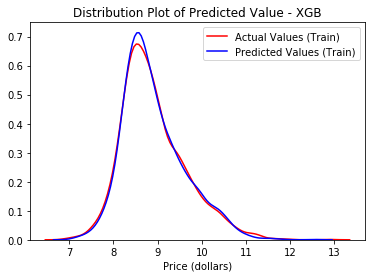

In [608]:
DistributionPlot(y_test, pred)

In [609]:
# save model
with open('rf_cv.pkl', 'wb') as f:
    pickle.dump(xgb_cv.best_params_, f)

### Keras

In [614]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [615]:
# set seed
np.random.seed(0)

In [618]:
model = Sequential()
model.add(Dense(200, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               3200      
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 26        
Total params: 29,651
Trainable params: 29,651
Non-trainable params: 0
_________________________________________________________________


In [619]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)


Epoch 1/100
8795/8795 [==============================] - 2s 279us/step - loss: 1.9522
Epoch 2/100
8795/8795 [==============================] - 2s 203us/step - loss: 0.2137
Epoch 3/100
8795/8795 [==============================] - 2s 203us/step - loss: 0.2271
Epoch 4/100
8795/8795 [==============================] - 2s 211us/step - loss: 0.2503
Epoch 5/100
8795/8795 [==============================] - 2s 219us/step - loss: 0.2139
Epoch 6/100
8795/8795 [==============================] - 2s 215us/step - loss: 0.2248
Epoch 7/100
8795/8795 [==============================] - 2s 201us/step - loss: 0.2122
Epoch 8/100
8795/8795 [==============================] - 2s 202us/step - loss: 0.2240
Epoch 9/100
8795/8795 [==============================] - 2s 202us/step - loss: 0.2072
Epoch 10/100
8795/8795 [==============================] - 2s 205us/step - loss: 0.2181
Epoch 11/100
8795/8795 [==============================] - 2s 206us/step - loss: 0.2039
Epoch 12/100
8795/8795 [===========================

In [621]:
model.evaluate(X_train, y_train)
pred = model.predict(X_test)

8795/8795 [==============================] - 0s 24us/step


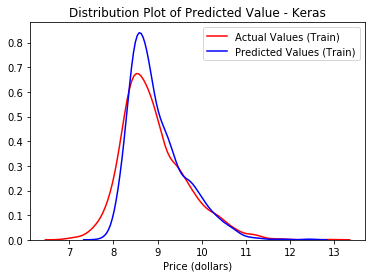

In [624]:
DistributionPlot(y_test, pred)

2. cluster the data 

In [768]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [747]:
X = df_clean.iloc[:, 1:-1]
X = MinMaxScaler().fit_transform(X)

In [766]:
# find pca 
variance_exp = []
variance = []
for p in range(1, 15):
    pca = PCA(n_components=p)
    pca.fit_transform(X)
    variance_exp.append(sum(pca.explained_variance_ratio_))
    variance.append(pca.explained_variance_)

In [748]:
# find the best k 
inertias = [] 
K = range(1,20) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
    inertias.append(kmeanModel.inertia_) 

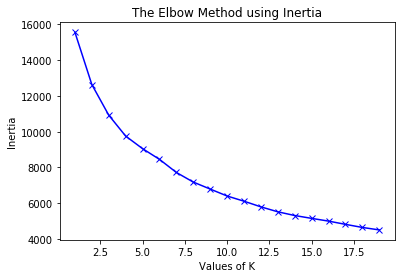

In [749]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [770]:
def build_model(pca_n=8, n_clusters=7):
    '''Creates a pipeline for doing KMeans clustering
    
    Args:
        pca_n (int): number of pca components
        n_clusters (int): number of clusters
    
    Returns:
        pipeline (sklearn.pipeline.Pipeline)
    '''
    pipeline = Pipeline([
            ('scale', MinMaxScaler()),
            ('pca', PCA(pca_n)),
            ('kmeans', KMeans(n_clusters=n_clusters, random_state=0))
    ])
    
    return pipeline

In [772]:
# fit into original data
model = build_model()
model.fit(X)
pred = model.predict(X)

In [774]:
df_clean['label'] = pred

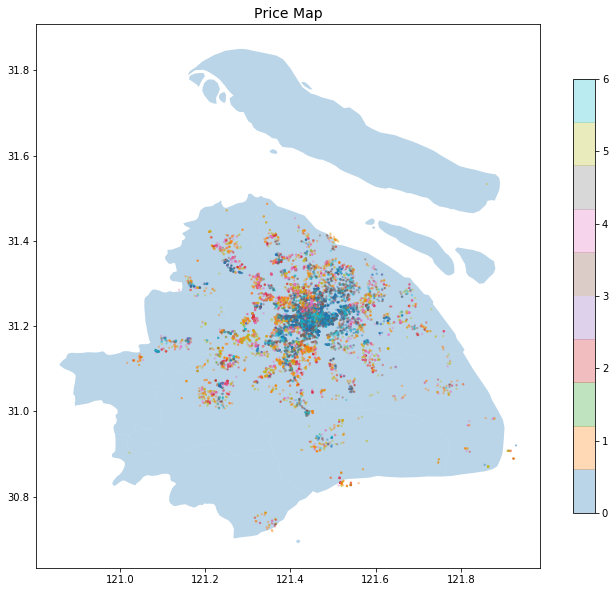

In [775]:
gpd.plot(figsize=(12,10), alpha=0.3)
scatter_map = plt.scatter(data=df_clean, x='lon', y='lat', c='label', alpha=0.3, cmap='tab10', s=2)
plt.colorbar(shrink = 0.8)
plt.title('Price Map', fontsize=14);

In [807]:
# check important features
for i in range(7):
    print(model.named_steps['kmeans'].cluster_centers_[i].argmax(),
          model.named_steps['kmeans'].cluster_centers_[i].argmin())

1 0
0 1
2 1
1 3
3 1
3 2
1 2


In [812]:
summary = pd.DataFrame(columns=df_clean.columns[1:-1], 
                       data=model.named_steps['pca'].components_[:4]).drop('log_price', axis=1).T

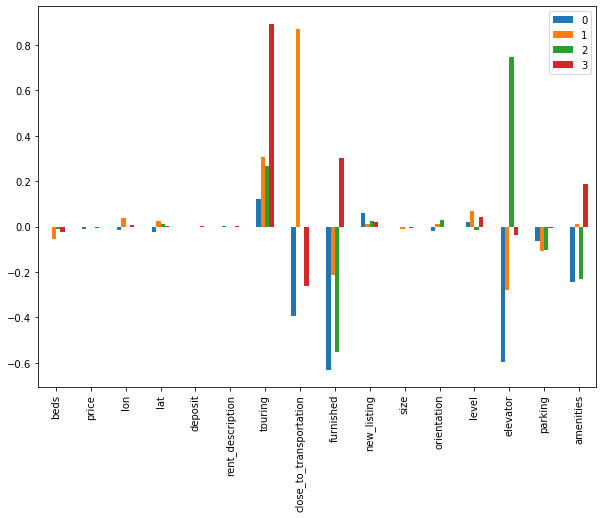

In [817]:
summary.plot(figsize=(10, 7), kind='bar');